In [13]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [14]:
#define the training filepath
filename_aug_train = '/Users/shreyajaiswal/Library/CloudStorage/OneDrive-NortheasternUniversity/Projects/MLOps-NYC-Taxi/experiment_tracking/dataset/yellow_tripdata_2023-08.parquet'
filename_sept_validate = '/Users/shreyajaiswal/Library/CloudStorage/OneDrive-NortheasternUniversity/Projects/MLOps-NYC-Taxi/experiment_tracking/dataset/yellow_tripdata_2023-09.parquet'
model_output_filepath = '/Users/shreyajaiswal/Library/CloudStorage/OneDrive-NortheasternUniversity/Projects/MLOps-NYC-Taxi/experiment_tracking/model'

In [26]:
#define the training filepath
filename_aug_train = './dataset/yellow_tripdata_2023-08.parquet'
filename_sept_validate = './dataset/yellow_tripdata_2023-09.parquet'
model_output_filepath = './model'

In [27]:
import mlflow

# Set the tracking URI to use SQLite as the backend store
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set the experiment name mlflow
experiment_name = "POC_NYC-Yellow-Taxi-Experiment"
mlflow.set_experiment(experiment_name)

2023/12/04 21:08:18 INFO mlflow.tracking.fluent: Experiment with name 'POC_NYC-Yellow-Taxi-Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1701742098822, experiment_id='3', last_update_time=1701742098822, lifecycle_stage='active', name='POC_NYC-Yellow-Taxi-Experiment', tags={}>

filename_sept_train = './dataset/yellow_tripdata_2023-08.parquet'
filename_aug_validate = './dataset/yellow_tripdata_2023-09.parquet'
model_output_filepath = './model/linear_regression'

In [28]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        
        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
        
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
        
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df
        

In [29]:
df_train = read_dataframe(filename_aug_train)
df_validate = read_dataframe(filename_sept_validate)

In [30]:
len(df_train), len(df_validate)

(2749262, 2742971)

In [31]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_validate['PU_DO'] = df_validate['PULocationID'] + '_' + df_validate['DOLocationID']

In [32]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_validate[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [33]:
target = 'duration'
y_train = df_train[target].values
y_val = df_validate[target].values

In [22]:
#Fitting the linear regression model to the training data 
def model_linear_regression(X_train,y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    #using the trained model to predict outcome of the validation data
    y_pred = lr.predict(X_val)

    print("The mean square error is --> ", mean_squared_error(y_val, y_pred, squared=False))
    return y_pred, mean_squared_error(y_val, y_pred, squared=False)

The mean square error is -->  7.156963179253967


/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_37221/2108171495.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_lr, label='prediction_linear_regression')
/var/folders/c9/wytgs3g14698n1_9r5l9959c0000gn/T/ipykernel_37221/2108171495.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

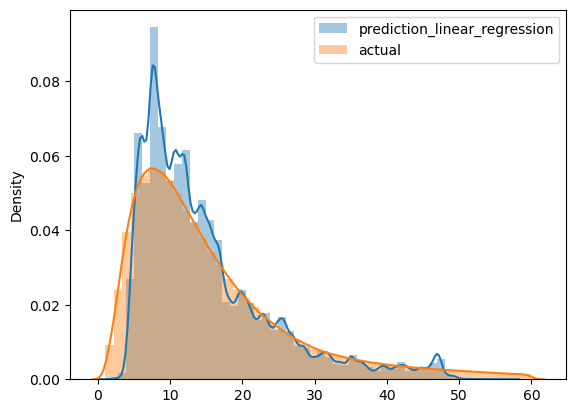

In [12]:
y_pred_lr, rmse =model_linear_regression(X_train,y_train)
sns.distplot(y_pred_lr, label='prediction_linear_regression')
sns.distplot(y_train, label='actual')

plt.legend()

In [23]:
with mlflow.start_run():

    mlflow.set_tag("developers","mlops-nyc-yellow-taxi")
    mlflow.log_param("train-data_path",f"{filename_aug_train}")
    mlflow.log_param("validate-data_path",f"{filename_sept_validate}")

    alpha = 0.01

    mlflow.log_param("alpha",f"{alpha}")
    y_pred_lr, rmse =model_linear_regression(X_train,y_train)

    mlflow.log_metric("rmse", rmse)
    


The mean square error is -->  7.156963179253967


In [ ]:
ls = Lasso(0.01)
ls.fit(X_train, y_train)

y_pred_ls= ls.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.894920188834673

In [ ]:
sns.distplot(y_pred_ls, label='prediction_lasso')
sns.distplot(y_train, label='actual')

plt.legend()

In [ ]:
rd = Ridge(0.01)
rd.fit(X_train, y_train)

y_pred_rd = ls.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.894920188834673

In [ ]:
sns.distplot(y_pred_rd, label='prediction_ridge')
sns.distplot(y_train, label='actual')

plt.legend()

In [ ]:
with open(f'{model_output_filepath}/lr-v-1.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)
    print("sucessfully recorded current model")

sucessfully recorded current model


In [ ]:
with mlflow.start_run():

    mlflow.set_tag("developers","shreya","nyc-yellow-taxi","mlops")
    mlflow.log_param("train-data_path",f"{filename_aug_train}")
    mlflow.log_param("validate-data_path",f"{filename_sept_validate}")

    alpha = 0.01

    mlflow.log_param("alpha",f"{alpha}")
    


In [35]:
import xgboost as xgb

In [36]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [37]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [46]:

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1,
            evals=[(valid, 'validation')],
            early_stopping_rounds=5
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [47]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=2,
    trials=Trials()
)

[21:24:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.26539                         
[21:24:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.83631                                                  
100%|██████████| 2/2 [00:10<00:00,  5.28s/trial, best loss: 18.26538967228935]


In [45]:
params = {
    
}
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

[0]	validation-rmse:15.17697
[1]	validation-rmse:12.10702
[2]	validation-rmse:10.16283
[3]	validation-rmse:8.97004
[4]	validation-rmse:8.25446
[5]	validation-rmse:7.82822
[6]	validation-rmse:7.57144
[7]	validation-rmse:7.41582
[8]	validation-rmse:7.31678
[9]	validation-rmse:7.25463
[10]	validation-rmse:7.21052
[11]	validation-rmse:7.18120
[12]	validation-rmse:7.16340
[13]	validation-rmse:7.14726
[14]	validation-rmse:7.13738
[15]	validation-rmse:7.13038
[16]	validation-rmse:7.12439
[17]	validation-rmse:7.11979


KeyboardInterrupt: 

In [ ]:
params = {
    
}

mlflow.xgboost.autolog()

with mlflow.start_run():
    mlflow.set_tag()
    mlflow.log_param()

    booster = xgb.train(
        booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
)
    )